In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
!unzip '/content/drive/MyDrive/CS613 Project/OASIS_alzheimer.zip' &> /dev/null

In [ ]:
from PIL import Image as I
from PIL import ImageFilter
import pandas as pd
import numpy as np
import os
import cv2
import shutil
import random
from distutils.file_util import copy_file
from statistics import mode
from sklearn.model_selection import train_test_split as split
from sklearn.metrics import confusion_matrix as cm
np.set_printoptions(suppress=True)

In [ ]:
non = '/content/Data/Non Demented'
vmild = '/content/Data/Very mild Dementia'
mild = '/content/Data/Mild Dementia'
mod = '/content/Data/Moderate Dementia'

In [ ]:
listmod = []
listnon = []
listvmild = []
listmild = []

for root, directories, files in os.walk(mod):
    for name in files:
        listmod.append(os.path.join(root, name))
for root, directories, files in os.walk(non):
    for name in files:
        listnon.append(os.path.join(root, name))
for root, directories, files in os.walk(vmild):
    for name in files:
        listvmild.append(os.path.join(root, name))
for root, directories, files in os.walk(mild):
    for name in files:
        listmild.append(os.path.join(root, name))

# Shuffle lists for random train / test
seed_value = 0
random.seed(seed_value)
random.shuffle(listmod)
random.shuffle(listnon)
random.shuffle(listvmild)
random.shuffle(listmild)

!mkdir ./Newdata
!mkdir ./Newdata/mildtrain
!mkdir ./Newdata/nontrain
!mkdir ./Newdata/vmildtrain
!mkdir ./Newdata/modtrain
!mkdir ./Newdata/mildtest
!mkdir ./Newdata/nontest
!mkdir ./Newdata/vmildtest
!mkdir ./Newdata/modtest

In [ ]:
pvmild = '/content/Newdata/vmildtrain'
pnon = '/content/Newdata/nontrain'
pmild = '/content/Newdata/mildtrain'
pmod = '/content/Newdata/modtrain'
tvmild = '/content/Newdata/vmildtest'
tnon = '/content/Newdata/nontest'
tmild = '/content/Newdata/mildtest'
tmod = '/content/Newdata/modtest'
n=488
for i in range(n):  #to get a balanced class prior, since lowest class count is 488
  if i<=(n*(2/3)):
      copy_file(listvmild[i], pvmild)
      copy_file(listmild[i], pmild)
      copy_file(listnon[i], pnon)
      copy_file(listmod[i], pmod)
  else:
    copy_file(listvmild[i], tvmild)
    copy_file(listmild[i], tmild)
    copy_file(listnon[i], tnon)
    copy_file(listmod[i], tmod)

In [7]:
dir =[ [pnon, pmild], [pnon, pvmild], [pnon, pmod], [pmild, pvmild], [pmild, pmod], [pvmild, pmod] ]

weights = [] #to return weights for each system
pcas = [] #to return eigenvector for dimension reduction
means = [] #to return training data mean to zero-mean for each weight
zero_means = [] #to return prediction mean of X_train_0 to compare in test for each weight
one_means = [] #to return prediction mean of X_train_1 to compare in test for each weight

for k in range(6):
  main_image_list = []
  labels = []
  for i in range(2):
      location = sorted( os.listdir( dir[k][i] ) )
      image_list = []
      label_list = []
      for file_name in location:
          file_path = os.path.join( dir[k][i] , file_name )
          image = I.open(file_path)

###########Blur
          # image = image.filter(ImageFilter.GaussianBlur(radius=2))

          new_image = image.convert('L').resize(( 128, 64)) #downsampling image for ease of computation
          image2D = np.array(new_image) #reading 2D matrix

###########Canny edge
          # image2D = cv2.Canny(image2D, 50, 150)

          image1D = image2D.flatten() #flattening to 1D matrix
          image_list.append(image1D)
          label_list.append(i)

      concatenated_images = np.vstack(image_list) #concatinating list vertically to get 326xfeatures shape
      concatenated_labels = np.vstack(label_list)
      print(concatenated_images.shape)
      main_image_list.append(concatenated_images)
      labels.append(concatenated_labels)

  main_image_list = np.vstack(main_image_list)
  labels = np.vstack(labels)

  data = np.concatenate((labels, main_image_list), axis=1)
  df = pd.DataFrame(data)

  random_seed = 0
  train_df = df.sample(frac=1, random_state = random_seed)

  X_train = train_df.iloc[:,1:].values
#### ZERO-MEAN
  mean = X_train.mean()
  X_train = (X_train - mean)
#### ZERO-MEAN
###################### PCA
  train_cov = np.cov(X_train, rowvar = False)
  e1,vec = np.linalg.eig(train_cov)
  vec = vec[:,np.argsort(e1)[::-1]]
  e_proj = vec[:,:1500]
  X_train = np.dot(X_train,e_proj)
###################### PCA
  Y_train = train_df.iloc[:,:1].values
  Y_train = Y_train.flatten()

  X_train_0 = X_train[Y_train == 0]
  X_train_1 = X_train[Y_train == 1]
  mean_0 = np.mean(X_train_0,axis=0)
  mean_1 = np.mean(X_train_1,axis=0)
  cov_0 = np.cov(X_train_0,rowvar=False)
  cov_1 = np.cov(X_train_1,rowvar=False)
  Sw = cov_0 + cov_1
  Sb = np.outer((mean_0 - mean_1).T, (mean_0 - mean_1))

  eigenvalues, eigenvectors = np.linalg.eig((np.linalg.pinv(Sw)) @ Sb)
  nz_eig = np.argmax(eigenvalues)
  w = eigenvectors[:, nz_eig]

  M0 = np.mean(X_train_0 @ w)
  M1 = np.mean(X_train_1 @ w)

  weights.append(w) # storing weights
  pcas.append(e_proj) # storing vector to pca X_test
  means.append(mean) # storing mean to zero mean X_test
  zero_means.append(M0) #storing mean of 0 to determine pred label
  one_means.append(M1) #storing mean of 1 to determine pred label


(326, 8192)
(326, 8192)
(326, 8192)
(326, 8192)
(326, 8192)
(326, 8192)
(326, 8192)
(326, 8192)
(326, 8192)
(326, 8192)
(326, 8192)
(326, 8192)


In [8]:
new_dir = [ tnon, tmild, tvmild, tmod ]

test_main_image_list = []
test_labels = []

for i in range(4):
    location = sorted( os.listdir( new_dir[i] ) )
    image_list = []
    label_list = []
    for file_name in location:
        file_path = os.path.join( new_dir[i] , file_name )
        image = I.open(file_path)

#########Blur
        # image = image.filter(ImageFilter.GaussianBlur(radius=2))

        new_image = image.convert('L').resize((128, 64)) #downsampling image for ease of computation
        image2D = np.array(new_image) #reading 2D matrix

#########Canny edge
        # image2D = cv2.Canny(image2D, 50, 150)

        image1D = image2D.flatten() #flattening to 1D matrix
        image_list.append(image1D)
        label_list.append(i)

    concatenated_images = np.vstack(image_list) #concatinating list vertically get 162xfeatures shape
    concatenated_labels = np.vstack(label_list)
    print(concatenated_images.shape)
    test_main_image_list.append(concatenated_images)
    test_labels.append(concatenated_labels)



test_main_image_list = np.vstack(test_main_image_list)
test_labels = np.vstack(test_labels)

tdata = np.concatenate((test_labels, test_main_image_list), axis=1)
test_df = pd.DataFrame(tdata)

test_df = test_df.sample(frac=1, random_state = 3)

X_test = test_df.iloc[:,1:].values
Y_test = test_df.iloc[:,:1].values

Y_test = Y_test.flatten()

(162, 8192)
(162, 8192)
(162, 8192)
(162, 8192)


In [9]:
list_num = [ [0,1], [0,2], [0,3], [1,2], [1,3], [2,3] ]
final_pred = []

for k in range ( np.shape(X_test)[0] ):
  result = []
  for l in range ( np.shape(weights)[0] ):

    X_test_k = (X_test[k] - means[l]) #ZERO-MEAN
    X_test_k = np.dot(X_test_k, pcas[l]) #PCA

    y_pred_val = np.dot(X_test_k, weights[l])

    a = abs(y_pred_val - zero_means[l])
    b = abs(y_pred_val - one_means[l])

    if a < b:
      final = list_num[l][0]
    else:
      final = list_num[l][1]

    result.append(final)

  final_pred.append(mode(result))

#accuracy
np.mean(Y_test == final_pred)

0.7746913580246914

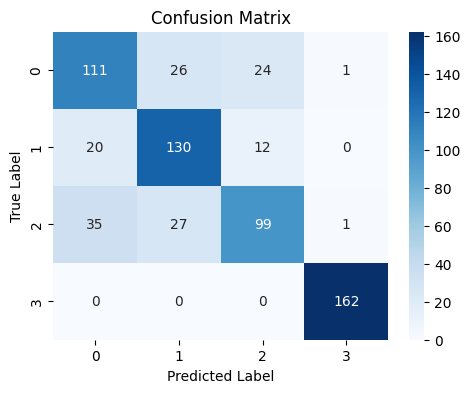

In [10]:
import matplotlib.pyplot as plt
import seaborn as sns
cm1 = cm(Y_test, final_pred)

# Plotting the confusion matrix
plt.figure(figsize=(5.4, 4))
sns.heatmap(cm1, annot=True, fmt="d", cmap="Blues", xticklabels=[0,1,2,3], yticklabels=[0,1,2,3])
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

In [13]:
####Exporting weights

!mkdir ./128_LDA
np.save('/content/128_LDA/128_LDA_weights.npy', weights)
np.save('/content/128_LDA/128_LDA_pcas.npy', pcas)
np.save('/content/128_LDA/128_LDA_means.npy', means)
np.save('/content/128_LDA/128_LDA_zero_means.npy', zero_means)
np.save('/content/128_LDA/128_LDA_one_means.npy', one_means)

New = '/content/128_LDA'
zip_filename = '/content/128_LDA'
shutil.make_archive(zip_filename, 'zip', New)

# !mkdir ./64_LDA
# np.save('/content/64_LDA/64_LDA_weights.npy', weights)
# np.save('/content/64_LDA/64_LDA_pcas.npy', pcas)
# np.save('/content/64_LDA/64_LDA_means.npy', means)
# np.save('/content/64_LDA/64_LDA_zero_means.npy', zero_means)
# np.save('/content/64_LDA/64_LDA_one_means.npy', one_means)

# New = '/content/64_LDA'
# zip_filename = '/content/64_LDA'
# shutil.make_archive(zip_filename, 'zip', New)

mkdir: cannot create directory ‘./128_LDA’: File exists


'/content/128_LDA.zip'

In [14]:
# !cp 128_LDA.zip '/content/drive/MyDrive/CS613 Project'
# !cp 64_LDA.zip '/content/drive/MyDrive/CS613 Project'